In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import os
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn import decomposition

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorboard import notebook

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import decomposition
from sklearn import discriminant_analysis

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn
import scipy.io
import numpy
import cv2

from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_curve,auc
def eval_model(model):
    #predict Test Accuracy
    test_scores = model.evaluate(test,test_y,verbose=2)
    print("Testing Loss: "+str(test_scores[0]))
    print("Testing Accuracy: "+str(test_scores[1]))

    #display the ROC Curve
    classes = numpy.unique(train_y)
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1)
    for i in range(10):
        fpr,tpr,_=roc_curve(test_y,pred[:,i],pos_label=classes[i])
        auc_score = auc(fpr,tpr)
        ax.plot(fpr,tpr,label='%s: %0.2f' % (classes[i],auc_score))
    ax.legend()

    #confusion matrix
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1)
    pred = model.predict(test)
    indexes = tf.argmax(pred,axis=1)
    cm = confusion_matrix(test_y,indexes)
    c = ConfusionMatrixDisplay(cm,display_labels=range(10))
    c.plot(ax=ax)
    ax.set_title('Testing Performance')
    eval_model(new_model)


In [8]:
root_dir = os.path.abspath(os.getcwd())+"/256_ObjectCategories/"
#add the arrays that we can use for training and testing
main_x = []
main_y = []
prev_file = [""]
current_index = 0
for subdir, dirs, files in os.walk(root_dir):
    for dir in dirs:
        current_dir = os.path.join(root_dir) + dir
        after = str(current_dir.split(".",1)[1])
        for file in os.listdir(current_dir):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                current_file = cv2.imread(os.path.join(current_dir,filename),0)
                current_file = cv2.resize(current_file, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
                color_features = current_file.flatten()
                grey_image = rgb2gray(current_file)
                hog_features = hog(grey_image,block_norm='L2-Hys',pixels_per_cell=(16,16))
                flat_features = np.hstack(color_features)
                main_x.append(flat_features)
                main_y.append(current_index)
                continue
            else:
                continue
        current_index = current_index+1
    break
images_x = np.array(main_x)
images_y = np.array(main_y)
print(np.shape(images_x))

C:\Users\harry\Anaconda3\envs\Cab\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


(30607, 7560)


In [9]:
print(images_x[0])

[118 127 143 ... 126 131 124]


In [10]:
temp_x_train, x_test, temp_y_train, y_test = train_test_split(images_x,images_y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(temp_x_train,temp_y_train,test_size=0.2,random_state=42)
print(numpy.shape(x_train))
print(numpy.shape(x_test))
print(numpy.shape(x_val))

(19588, 7560)
(6122, 7560)
(4897, 7560)


int32


IndexError: too many indices for array

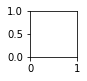

In [11]:
# print(images_y.dtype)
# fig = plt.figure(figsize=[10,10])
# for i in range(100):
#     ax = fig.add_subplot(10,10,i+1)
#     ax.imshow(x_train[i,:,:])

In [12]:
#THIS DATA IS ONLY FOR THE CNN, IT WONT WORK FOR KNN OR SVM
root_dir = os.path.abspath(os.getcwd())+"/256_ObjectCategories/"
#add the arrays that we can use for training and testing
main_x = []
main_y = []
prev_file = [""]
current_index = 0
for subdir, dirs, files in os.walk(root_dir):
    for dir in dirs:
        current_dir = os.path.join(root_dir) + dir
        after = str(current_dir.split(".",1)[1])
        for file in os.listdir(current_dir):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                current_file = cv2.imread(os.path.join(current_dir,filename),0)
                current_file = cv2.resize(current_file, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
                main_x.append(current_file)
                main_y.append(current_index)
                continue
            else:
                continue
        current_index = current_index+1
    break
images_x = np.array(main_x)
images_y = np.array(main_y)
print(np.shape(images_x))

In [13]:
print(np.shape(images_y))

(30607,)


In [14]:
#apply PCA and dimension reduction to the data
pca = decomposition.PCA()
pca.fit(images_x)
transformed = pca.transform(images_x)
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(transformed,images_y)
new_data = lda.transform(transformed)
print(new_data.shape)

(30607, 256)


In [15]:
print(images_y.shape)

(30607,)


In [16]:
temp_x_train, x_test, temp_y_train, y_test = train_test_split(new_data,images_y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(temp_x_train,temp_y_train,test_size=0.2,random_state=42)
print(numpy.shape(x_train))
print(numpy.shape(x_test))
print(numpy.shape(x_val))
print(images_y[0])
print(images_y[99])

(19588, 256)
(6122, 256)
(4897, 256)
0
1


In [27]:
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
def get_compiled_model():knn_clf = KNeighborsClassifier()
    param_distributions = {"leaf_size": uniform(1,20),"n_neighbors": uniform(1,20),"p":uniform(1,2)}
    rnd_search_cv = RandomizedSearchCV(knn_clf, param_distributions, n_iter=10, verbose=2, cv=3)
    rnd_search_cv.fit(x_train, y_train)
    rnd_search_cv.best_estimator_
    rnd_search_cv.best_score_
    return rnd_search_cv.best_estimator_

def make_or_restore_model():
    #either restore the latest model or create a fresh one if theres no checkpoint available
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints,key=os.path.getctime)
        print("restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()

def run_training():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = make_or_restore_model()
    callbacks = [
        # this callback saves a saved model every epoch
        # we can include the current epoch in the folder name
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}",save_freq="epoch"
        )
    ]
    model.fit(x_train,y_train)
    return model

#the first run creates the model
run_training()

#the second time you call it will pick off from the last saved point
run_training()

C:\Users\harry\Anaconda3\envs\Cab\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Best leaf_size: 1
Best p: 2
Best n_neighbors: 1


0.2206795164978765

In [28]:
#setup the SVM
#grid search cross validation has already been imported ready for hyperparameter tuning
svm = SVC(class_weight='balanced')
#add some stuff for some shitty hyperparameter tuning here. You guys figure out the smarter way to do it. I belive the smarter way is using the range functionality to narrow down the range of values but you will need to investigate
#param_grid = [
#    {'C':[0.1,1,10,100],'kernel':['linear']},
#    {'C':[0.1,1,10,100],'gamma':[0.1,0.01,0.001],'kernel':['rbf']},
#    {'C':[0.1,1,10,100],'degree':[3,4,5],'kernel':['poly']},
#]
#grid_search = GridSearchCV(svm, param_grid)
#grid_search.fit(x_train,y_train)
#grid_search.cv_results_
#best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
#params = grid_search.cv_results_['params'][best_system]
#print(params)
#svm = SVC().set_params(**params)
svm.fit(x_train,y_train)

SVC(class_weight='balanced')

In [44]:
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
def get_compiled_model():
    svm_clf = SVC(gamma="scale")

    param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
    rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
    rnd_search_cv.fit(x_train, y_train)
    rnd_search_cv.best_estimator_
    rnd_search_cv.best_score_
    return rnd_search_cv.best_estimator_

def make_or_restore_model():
    #either restore the latest model or create a fresh one if theres no checkpoint available
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints,key=os.path.getctime)
        print("restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()

def run_training():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = make_or_restore_model()
    callbacks = [
        # this callback saves a saved model every epoch
        # we can include the current epoch in the folder name
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}",save_freq="epoch"
        )
    ]
    model.fit(x_train,y_train)

#the first run creates the model
run_training()

#the second time you call it will pick off from the last saved point
run_training()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Creating a new model


NameError: name 'reciprocal' is not defined

In [9]:
num_epochs = 100

def build_model(num_classes,output_activation=None):
    inputs = keras.Input(shape=(140,54,1),name='img')
    x = layers.Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.35)(x) #removes some of the learned features
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(4, 4))(x) #makes images softer to remove slight changes to reduce feature maps - downsampling and keeps details
    
    x = layers.Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.35)(x) #removes some of the learned features
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(4, 4))(x) #makes images softer to remove slight changes to reduce feature maps - downsampling and keeps details
    
    x = layers.Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.35)(x) #removes some of the learned features
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(4, 4))(x) #makes images softer to remove slight changes to reduce feature maps - downsampling and keeps details
    
    x = layers.Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.35)(x) #removes some of the learned features
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(4, 4))(x) #makes images softer to remove slight changes to reduce feature maps - downsampling and keeps details
    
    x = layers.Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.35)(x) #removes some of the learned features
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(4, 4))(x) #makes images softer to remove slight changes to reduce feature maps - downsampling and keeps details
    # rinse and repeat with 2D convs, batch norm, dropout and max pool

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(258,activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')

    return model_cnn

model_cnn = build_model(257)
model_cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 140, 54, 1)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 140, 54, 8)        80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 140, 54, 8)        584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 140, 54, 8)        32        
_________________________________________________________________
activation_3 (Activation)    (None, 140, 54, 8)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 140, 54, 8)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 70, 27, 8)         0       

In [10]:
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
def get_compiled_model():
    build_model(257)

def make_or_restore_model():
    #either restore the latest model or create a fresh one if theres no checkpoint available
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints,key=os.path.getctime)
        print("restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()

def run_training():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = make_or_restore_model()
    callbacks = [
        # this callback saves a saved model every epoch
        # we can include the current epoch in the folder name
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}",save_freq="epoch"
        )
    ]
    model_cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
    history = model_cnn.fit(x_train,y_train,
    batch_size=256,
    epochs=num_epochs,
    validation_data=(x_test,y_test))


#the first run creates the model
run_training()

#the second time you call it will pick off from the last saved point
run_training()

Epoch 1/50
97/97 [==============================] - 218s 2s/step - loss: 12.7732 - accuracy: 0.0095 - val_loss: 13.6953 - val_accuracy: 0.0265
Epoch 2/50
97/97 [==============================] - 200s 2s/step - loss: 13.7586 - accuracy: 0.0221 - val_loss: 13.4132 - val_accuracy: 0.0199
Epoch 3/50
97/97 [==============================] - 217s 2s/step - loss: 13.7847 - accuracy: 0.0154 - val_loss: 13.8386 - val_accuracy: 0.0212
Epoch 4/50
97/97 [==============================] - 198s 2s/step - loss: 14.0584 - accuracy: 0.0155 - val_loss: 13.8053 - val_accuracy: 0.0222
Epoch 5/50
97/97 [==============================] - 232s 2s/step - loss: 14.2489 - accuracy: 0.0287 - val_loss: 16.2949 - val_accuracy: 0.0114
Epoch 6/50
97/97 [==============================] - 232s 2s/step - loss: 12.0226 - accuracy: 0.0072 - val_loss: 5.5491 - val_accuracy: 0.0049
Epoch 7/50
97/97 [==============================] - 218s 2s/step - loss: 5.5503 - accuracy: 0.0034 - val_loss: 5.5491 - val_accuracy: 0.0042
Ep

KeyboardInterrupt: 